# Mounting the notebook to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

img_path = "/content/drive/MyDrive/PVOUT map.png"  # 👈 your current path

print("File exists:", os.path.exists(img_path))


File exists: False


100%|██████████| 4/4 [00:00<00:00, 33.10it/s]


✅ Created 9 image tiles saved to: /content/drive/MyDrive/pvout_patches/


100%|██████████| 12/12 [00:00<00:00, 20.58it/s]

✅ Automatically labeled patches based on brightness.
Found 159 images belonging to 3 classes.
Found 38 images belonging to 3 classes.



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5633 - loss: 1.4276 - val_accuracy: 0.7895 - val_loss: 0.3310
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9578 - loss: 0.1577 - val_accuracy: 0.7895 - val_loss: 0.6242
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8701 - loss: 0.2500 - val_accuracy: 0.7895 - val_loss: 0.3190
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9676 - loss: 0.0630 - val_accuracy: 0.8684 - val_loss: 0.3285
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9842 - loss: 0.0272 - val_accuracy: 0.8684 - val_loss: 0.3186
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9980 - loss: 0.0148 - val_accuracy: 0.8158 - val_loss: 0.5887
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.8684 - val_loss: 0.4591
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.8421 - val_loss:

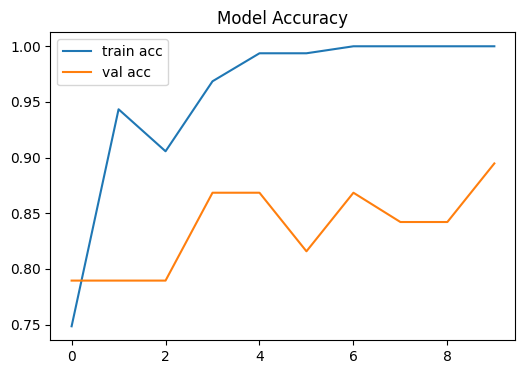

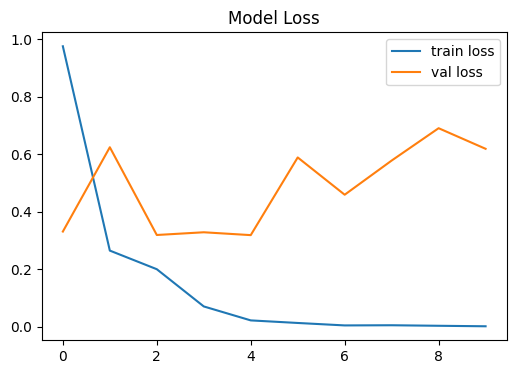

In [3]:
# ============================================
# 1. IMPORTS AND SETUP
# ============================================
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ============================================
# 2. LOAD IMAGE AND CREATE PATCHES
# ============================================
img_path = "PVOUT map.png"   # change if needed
output_dir = "/content/drive/MyDrive/pvout_patches/"
os.makedirs(output_dir, exist_ok=True)

# Load the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tile_size = 256
count = 0

for i in tqdm(range(0, img.shape[0], tile_size)):
    for j in range(0, img.shape[1], tile_size):
        patch = img[i:i+tile_size, j:j+tile_size]
        if patch.shape[0] == tile_size and patch.shape[1] == tile_size:
            cv2.imwrite(f"{output_dir}/tile_{count}.png", cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))
            count += 1

print(f"✅ Created {count} image tiles saved to: {output_dir}")

# ============================================
# 3. AUTO-LABEL PATCHES BY BRIGHTNESS
# ============================================
high_dir = os.path.join(output_dir, "high/")
medium_dir = os.path.join(output_dir, "medium/")
low_dir = os.path.join(output_dir, "low/")

# Create label directories
for d in [high_dir, medium_dir, low_dir]:
    os.makedirs(d, exist_ok=True)

for file in tqdm(os.listdir(output_dir)):
    file_path = os.path.join(output_dir, file)
    if os.path.isdir(file_path):   # skip folders
        continue
    if file.endswith(".png"):
        img_patch = np.array(Image.open(file_path))
        brightness = np.mean(img_patch)

        if brightness > 180:
            os.rename(file_path, os.path.join(high_dir, file))
        elif brightness > 100:
            os.rename(file_path, os.path.join(medium_dir, file))
        else:
            os.rename(file_path, os.path.join(low_dir, file))

print("✅ Automatically labeled patches based on brightness.")

# ============================================
# 4. DATA GENERATORS
# ============================================
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    output_dir,
    target_size=(256, 256),
    batch_size=8,
    subset='training'
)

val_gen = datagen.flow_from_directory(
    output_dir,
    target_size=(256, 256),
    batch_size=8,
    subset='validation'
)

# ============================================
# 5. BUILD SIMPLE CNN MODEL
# ============================================
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ============================================
# 6. TRAIN MODEL
# ============================================
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

# ============================================
# 7. PLOT ACCURACY AND LOSS
# ============================================
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [4]:
# After training your model like this:
# history = model.fit(train_gen, validation_data=val_gen, epochs=10)

# Extract metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print results clearly
print("📊 Training and Validation Metrics:")
print(f"Final Training Accuracy:     {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy:   {val_acc[-1]:.4f}")
print(f"Final Training Loss:         {train_loss[-1]:.4f}")
print(f"Final Validation Loss:       {val_loss[-1]:.4f}")

# Optional: show all epoch values
print("\n🔹 Epoch-wise Metrics:")
for epoch in range(len(train_acc)):
    print(f"Epoch {epoch+1}: "
          f"Train Acc={train_acc[epoch]:.4f}, "
          f"Val Acc={val_acc[epoch]:.4f}, "
          f"Train Loss={train_loss[epoch]:.4f}, "
          f"Val Loss={val_loss[epoch]:.4f}")


📊 Training and Validation Metrics:
Final Training Accuracy:     1.0000
Final Validation Accuracy:   0.8947
Final Training Loss:         0.0016
Final Validation Loss:       0.6188

🔹 Epoch-wise Metrics:
Epoch 1: Train Acc=0.7484, Val Acc=0.7895, Train Loss=0.9753, Val Loss=0.3310
Epoch 2: Train Acc=0.9434, Val Acc=0.7895, Train Loss=0.2648, Val Loss=0.6242
Epoch 3: Train Acc=0.9057, Val Acc=0.7895, Train Loss=0.2000, Val Loss=0.3190
Epoch 4: Train Acc=0.9686, Val Acc=0.8684, Train Loss=0.0706, Val Loss=0.3285
Epoch 5: Train Acc=0.9937, Val Acc=0.8684, Train Loss=0.0220, Val Loss=0.3186
Epoch 6: Train Acc=0.9937, Val Acc=0.8158, Train Loss=0.0131, Val Loss=0.5887
Epoch 7: Train Acc=1.0000, Val Acc=0.8684, Train Loss=0.0046, Val Loss=0.4591
Epoch 8: Train Acc=1.0000, Val Acc=0.8421, Train Loss=0.0052, Val Loss=0.5779
Epoch 9: Train Acc=1.0000, Val Acc=0.8421, Train Loss=0.0033, Val Loss=0.6904
Epoch 10: Train Acc=1.0000, Val Acc=0.8947, Train Loss=0.0016, Val Loss=0.6188


In [5]:
# =============================
# 1️⃣ Import Libraries
# =============================
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# =============================
# 2️⃣ Define Dataset Directories
# =============================
patch_dir = "/content/drive/MyDrive/pvout_patches/"
high_dir = os.path.join(patch_dir, "high/")
medium_dir = os.path.join(patch_dir, "medium/")
low_dir = os.path.join(patch_dir, "low/")

# Ensure directories exist
for d in [high_dir, medium_dir, low_dir]:
    os.makedirs(d, exist_ok=True)

# =============================
# 3️⃣ Auto Label Based on Brightness
# =============================
for file in tqdm(os.listdir(patch_dir)):
    file_path = os.path.join(patch_dir, file)

    # Skip directories
    if os.path.isdir(file_path):
        continue

    if file.endswith(".png"):
        img_patch = np.array(Image.open(file_path))
        brightness = np.mean(img_patch)

        if brightness > 180:
            os.rename(file_path, os.path.join(high_dir, file))
        elif brightness > 100:
            os.rename(file_path, os.path.join(medium_dir, file))
        else:
            os.rename(file_path, os.path.join(low_dir, file))

print("✅ Automatically labeled patches based on brightness.")


# =============================
# 4️⃣ Create Data Generators (with augmentation)
# =============================
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    patch_dir,
    target_size=(256, 256),
    batch_size=16,
    subset='training'
)

val_gen = datagen.flow_from_directory(
    patch_dir,
    target_size=(256, 256),
    batch_size=16,
    subset='validation'
)


# =============================
# 5️⃣ Define CNN Model with Regularization
# =============================
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define CNN model with L2 regularization and Dropout
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3),
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')  # 3 classes: high, medium, low
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model using generators
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate final metrics
train_loss, train_acc = model.evaluate(train_gen, verbose=0)
val_loss, val_acc = model.evaluate(val_gen, verbose=0)

print("📊 Training and Validation Metrics:")
print(f"Final Training Accuracy:     {train_acc:.4f}")
print(f"Final Validation Accuracy:   {val_acc:.4f}")
print(f"Final Training Loss:         {train_loss:.4f}")
print(f"Final Validation Loss:       {val_loss:.4f}")

# Epoch-wise metrics
print("\n🔹 Epoch-wise Metrics:")
for epoch in range(len(history.history['accuracy'])):
    print(f"Epoch {epoch+1}: "
          f"Train Acc={history.history['accuracy'][epoch]:.4f}, "
          f"Val Acc={history.history['val_accuracy'][epoch]:.4f}, "
          f"Train Loss={history.history['loss'][epoch]:.4f}, "
          f"Val Loss={history.history['val_loss'][epoch]:.4f}")


100%|██████████| 3/3 [00:00<00:00, 3141.80it/s]

✅ Automatically labeled patches based on brightness.
Found 159 images belonging to 3 classes.
Found 38 images belonging to 3 classes.


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5017 - loss: 1.8758 - val_accuracy: 0.7895 - val_loss: 0.6940
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8365 - loss: 0.5615 - val_accuracy: 0.7632 - val_loss: 0.6255
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9192 - loss: 0.4492 - val_accuracy: 0.9474 - val_loss: 0.6916
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9295 - loss: 0.4859 - val_accuracy: 0.8421 - val_loss: 0.5188
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9699 - loss: 0.3789 - val_accuracy: 0.9737 - val_loss: 0.3742
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9466 - loss: 0.3612 - val_accuracy: 0.9737 - val_loss: 0.5386
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9371 - loss: 0.3594 - val_accuracy: 0.7895 - val_loss: 0.5887
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9254 - loss: 0.3610 - val_accuracy: 0.8947 - val_loss:

In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    patch_dir,
    target_size=(224, 224),
    batch_size=16,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    patch_dir,
    target_size=(224, 224),
    batch_size=16,
    subset='validation'
)


Found 159 images belonging to 3 classes.
Found 38 images belonging to 3 classes.


In [8]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base layers for feature extraction
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_transfer_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.6170 - loss: 0.9746
Epoch 1: val_accuracy improved from -inf to 0.73684, saving model to best_transfer_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6209 - loss: 0.9691 - val_accuracy: 0.7368 - val_loss: 0.7475
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6674 - loss: 0.7882
Epoch 2: val_accuracy did not improve from 0.73684
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6725 - loss: 0.7827 - val_accuracy: 0.7368 - val_loss: 0.6593
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.7660 - loss: 0.6496
Epoch 3: val_accuracy did not improve from 0.73684
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7627 - loss: 0.6542 - val_accuracy: 0.7368 - val_loss: 0.6279
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.7288 - loss: 0.7221
Epoch 4: val_accuracy did not improve from 0.73684
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7277 - loss: 0.7186 - val_accuracy: 0.7368 - val_loss: 0.6073
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.7333 - loss: 0.6143
Epoch 5: val_accuracy did not improve from 0.7

In [11]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"📊 Final Metrics:")
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Loss:     {val_loss:.4f}")


📊 Final Metrics:
Training Accuracy:   0.7107
Validation Accuracy: 0.7368
Training Loss:       0.6250
Validation Loss:     0.5945


In [12]:
# Unfreeze last 50 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1573 - loss: 1.3359
Epoch 1: val_accuracy did not improve from 0.73684
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1585 - loss: 1.3351 - val_accuracy: 0.7368 - val_loss: 0.7549
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2901 - loss: 1.1950
Epoch 2: val_accuracy did not improve from 0.73684
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2929 - loss: 1.1925 - val_accuracy: 0.7368 - val_loss: 0.7603
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3364 - loss: 1.1611
Epoch 3: val_accuracy did not improve from 0.73684
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3339 - loss: 1.1609 - val_accuracy: 0.7368 - val_loss: 0.7657
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4132 - loss: 1.0976
Epoch 4: val_accuracy did not improve from 0.73684
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4145 - loss: 1.0984 - val_accuracy: 0.7368 - val_loss: 0.7700
Epoc

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [14]:
# ============================================
# DATA GENERATORS
# ============================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% for validation
)

train_gen = datagen.flow_from_directory(
    output_dir,
    target_size=(256, 256),
    batch_size=8,
    class_mode='categorical',   # ensure correct labels for multi-class
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    output_dir,
    target_size=(256, 256),
    batch_size=8,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 159 images belonging to 3 classes.
Found 38 images belonging to 3 classes.


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

# ✅ Define number of classes from generator
num_classes = train_gen.num_classes
print(f"Number of classes: {num_classes}")

# ✅ Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # freeze base model initially

# ✅ Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# ✅ Compile
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)



Number of classes: 3


/tmp/ipython-input-850370641.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 706ms/step - accuracy: 0.6426 - loss: 0.8908 - val_accuracy: 0.7632 - val_loss: 0.3999
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0.7843 - loss: 0.3725 - val_accuracy: 0.8421 - val_loss: 0.3551
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 0.8538 - loss: 0.3485 - val_accuracy: 0.8158 - val_loss: 0.3051
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.9044 - loss: 0.1990 - val_accuracy: 0.8684 - val_loss: 0.2871
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 507ms/step - accuracy: 0.9478 - loss: 0.1570 - val_accuracy: 0.8684 - val_loss: 0.2606
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 422ms/step - accuracy: 0.9548 - loss: 0.1196 - val_accuracy: 0.8684 - val_loss: 0.2500
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 560ms/step - accuracy: 0.9538 - loss: 0.1455 - val_accuracy: 0.8421 - val_loss: 0.2500
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - accuracy: 0.9710 - loss: 0.1056 - val_accurac

In [17]:
train_acc = model.evaluate(train_gen, verbose=0)[1]
val_acc = model.evaluate(val_gen, verbose=0)[1]
print(f"✅ Final Training Accuracy: {train_acc:.4f}")
print(f"✅ Final Validation Accuracy: {val_acc:.4f}")


✅ Final Training Accuracy: 1.0000
✅ Final Validation Accuracy: 0.8684


In [19]:
# Unfreeze last few layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(train_gen, validation_data=val_gen, epochs=5)


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 706ms/step - accuracy: 0.6340 - loss: 1.5432 - val_accuracy: 0.9211 - val_loss: 0.2591
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 658ms/step - accuracy: 0.7742 - loss: 0.4415 - val_accuracy: 0.8947 - val_loss: 0.2903
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 620ms/step - accuracy: 0.8575 - loss: 0.2906 - val_accuracy: 0.8158 - val_loss: 0.3177
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 623ms/step - accuracy: 0.8698 - loss: 0.3025 - val_accuracy: 0.8158 - val_loss: 0.3422
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 582ms/step - accuracy: 0.8744 - loss: 0.3198 - val_accuracy: 0.8158 - val_loss: 0.3636


In [20]:
# Save the entire model
model.save("/content/drive/MyDrive/solar_site_suitability_mobilenetv2.h5")

print("✅ Model saved successfully at: /content/drive/MyDrive/solar_site_suitability_mobilenetv2.h5")


✅ Model saved successfully at: /content/drive/MyDrive/solar_site_suitability_mobilenetv2.h5
